# 📊 04 - Uncertainty Analysis and Hotspot Prioritization (Conformal Prediction)

🧠 **Objective**  
This notebook applies **Conformal Prediction (CP)** to real-world crime data in order to quantify **predictive uncertainty** and its impact on hotspot detection.

We explore the predictive intervals obtained from CP and study their relation to true crime occurrences, allowing us to:

1. **Estimate uncertainty** using interval width and coverage (misscoverage).
2. **Classify hotspot cells** based on model performance.
3. **Propose a confidence metric** for each cell.
4. **Define a new priority map** to support decision-making.

📌 **Key Contributions**:
- Per-cell and per-time evaluation of uncertainty.
- Analysis of interval reliability across different hotspot categories.
- Introduction of a spatio-temporal **confidence score** combining coverage and interval width.
- Creation of **priority maps** to highlight cells that are frequent, uncertain, or reliable hotspots.


# 📦 Imports and Setup

We begin by importing core packages and custom utility functions.

- `data_partition` and `transformations`: for time-based splits and spatial transformations.
- `apply_conformal_mapie_per_cell`: wrapper for per-cell MAPIE calibration.
- `evaluation_cp`: contains functions to compute coverage, interval width, and confidence.
- `hotspot_classification`: utilities for classifying and prioritizing hotspot cells.

These modules are loaded dynamically from the project root to maintain compatibility with the `src/` directory structure.


In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))
sys.path.insert(0, project_root)

# Load modules

from src.utils.data_partition import temporal_split
from src.conformal.mapie_per_cell import apply_conformal_mapie_per_cell
from src.utils.transformations import aggregate_by_cell
from src.utils.spatial_processing import predictions_to_grid, grid_to_dataframe
from src.evaluation.evaluation_cp import (
                                            compute_misscoverage_per_cell,
                                            compute_overall_misscoverage,
                                            compute_interval_width_per_sample,
                                            compute_overall_interval_width,
                                            compute_spatiotemporal_confidence
                                         )
from src.evaluation.hotspot_classification import classify_temporal_hotspots, hotspot_priority

# ⚙️ Load Configuration, Data, and Model

We load global configuration parameters from `config.json`, which define:

- 🔢 Number of months for each partition (train, calibration, test)
- 🔍 Hotspot identification method (`by_crimes` or `by_cells`)
- 📊 Hotspot coverage percentage (`hotspot_percentage`)

### 📁 Data Sources

- **Crime Data**: Preprocessed file `df_used.csv` with aggregated counts per `(timestep, row, col)`
- **Geometry**: Shapefile of Chicago Police Beats (`geometry_path`)
- **Beat Map**: Dictionary that maps beat codes to `(row, col)` grid positions

### 🧠 Model Loading

We load a previously trained `NaivePerCellModel` using joblib.

### 🧪 Partitioning

Data is split into:
- **Train**
- **Calibration** (used for conformal prediction interval calibration)
- **Test** (used for evaluation and uncertainty quantification)

We extract features (`timestep`, `row`, `col`) and target (`count`) for both calibration and test sets.


In [21]:
# Load global config
config_path = os.path.join("../../", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default


# Partition data
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month

# Paths
data_dir = "../../data/real_data/Chicago/"
map_path = os.path.join(data_dir, "beat_to_coord_map.json")

path_dir="../../results/models/real_data/Chicago/"
naive_model = joblib.load(os.path.join(path_dir,"naive_cell_model.pkl"))

# Define path
data_path = "../../../../../uncertainty-informed-data/real_data/Chicago"
geometry_name = "PoliceBeatDec2012_20250410.csv"
geometry_path = os.path.join(data_path, geometry_name)

# Load data
gdf = gpd.read_file(os.path.abspath(geometry_path))
gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_wkt(gdf['the_geom'], crs=4326), data=gdf
)

# Load
df=pd.read_csv(os.path.join(data_dir,"df_used.csv"))
with open(map_path) as f:
    beat_to_coord_map = json.load(f)

rows, cols = tuple(df[["row","col"]].max()+1)
grid_size = (rows, cols)

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calibration_days, train_days + calibration_days + test_days)

# Define features
features = ["timestep", "row", "col"]
target = "count"

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()


import matplotlib.colors as mcolors

def plot_prediction_maps(
    gdf_base,
    df_list,
    columns=None,
    titles=None,
    cmap="YlOrRd",
    share_colorbar=True,
    suptitle=None,
    figsize=(12, 5),
    edgecolor="black",
    vmin=None,
    vmax=None,
    colorbar_labels=None
):
    """
    Plot multiple prediction maps side by side with optional shared or individual colorbars.

    Parameters:
    - gdf_base: GeoDataFrame with base geometry to merge with each df
    - df_list: list of DataFrames with 'beat' column and values to plot
    - columns: list of column names to plot, one per DataFrame
    - titles: list of titles for each subplot
    - cmap: str or colormap
    - share_colorbar: bool, whether to use a single shared colorbar
    - suptitle: optional super title
    - figsize: tuple, figure size
    - edgecolor: str, color of region edges
    - vmin, vmax: float, global color range (used only if share_colorbar=True)
    - colorbar_labels: list of str, used only if share_colorbar=False
    """

    n = len(df_list)
    if columns is None:
        raise ValueError("Must provide 'columns': one column name per DataFrame.")

    if len(columns) != n:
        raise ValueError("Length of 'columns' must match length of 'df_list'.")

    fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True)
    if n == 1:
        axes = [axes]

    # Shared normalization if requested
    norm = None
    if share_colorbar:
        global_min = min(df[col].min() for df, col in zip(df_list, columns)) if vmin is None else vmin
        global_max = max(df[col].max() for df, col in zip(df_list, columns)) if vmax is None else vmax
        norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

    for i, (df, col, ax) in enumerate(zip(df_list, columns, axes)):
        merged = gdf_base.merge(df, how="left", left_on="BEAT_NUM", right_on="beat")
        if share_colorbar:
            merged.plot(
                column=col, cmap=cmap, ax=ax, edgecolor=edgecolor, legend=False, norm=norm
            )
        else:
            merged.plot(
                column=col, cmap=cmap, ax=ax, edgecolor=edgecolor, legend=True,
                legend_kwds={"label": colorbar_labels[i] if colorbar_labels else col}
            )

        ax.set_title(titles[i] if titles else f"Map {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    # Shared colorbar
    if share_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cbar = fig.colorbar(sm, ax=axes, shrink=0.8)
        cbar.set_label(colorbar_labels[0] if colorbar_labels else columns[0])

    if suptitle:
        plt.suptitle(suptitle, fontsize=14)

    plt.show()



# 📏 Apply Conformal Prediction (MAPIE) per Cell

We use **MAPIE** to compute conformal prediction intervals for crime count prediction at the cell level.

### ⚙️ Parameters:
- **Base model**: NaivePerCellModel (already fitted)
- **Conformal method**: `"plus"` (conservative, valid for any base model)
- **Alpha**: 0.1 → target coverage = 90%

The function returns three grids:
- 🔽 `y_min`: Lower bound of the interval
- 🟢 `y_pred`: Point prediction
- 🔼 `y_max`: Upper bound of the interval

We **clip all lower bounds to zero**, as negative crime counts are not meaningful.

---

## 🖼️ Visualizing Prediction Intervals

We create maps showing:

- **Lower Bound** of the interval
- **Point Prediction** from the model
- **Upper Bound** of the interval

All maps use the same color scale (`YlOrRd`) and are visualized over the Chicago Police Beats geometry.

Applying MAPIE per cell using pre-trained Naive model...


Processing rows: 100%|██████████| 17/17 [00:00<00:00, 41.43it/s]
g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)
g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)
g:\Shared drives\Doctorado\Repositorios\u

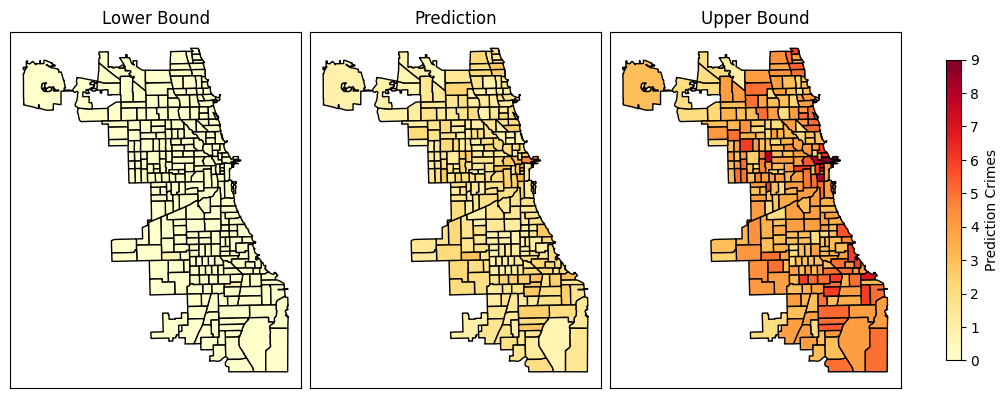

In [29]:
# Apply conformal prediction per cell using pre-trained model
print("Applying MAPIE per cell using pre-trained Naive model...")
y_pred, y_min, y_max = apply_conformal_mapie_per_cell(
    X_cal, y_cal, X_test,
    base_estimator=naive_model,
    alpha=0.1,
    method="plus",
    grid_size=grid_size,
    prefit=True
)

# Clip negative values to zero (makes sense for counts)
y_min = np.maximum(y_min, 0)
coord_to_beat_map = {tuple(v): k for k, v in beat_to_coord_map.items()}


grid_pred = y_pred 


grid_true = aggregate_by_cell(X_test, y_test, grid_size,aggfunc="mean")

df_pred=grid_to_dataframe(grid_pred, coord_to_beat_map, value_name="Prediction Crimes")
df_min=grid_to_dataframe(y_min, coord_to_beat_map, value_name="Prediction Crimes")
df_max=grid_to_dataframe(y_max, coord_to_beat_map, value_name="Prediction Crimes")


plot_prediction_maps(
    gdf[["BEAT_NUM","geometry"]],
    [df_min,df_pred,df_max],
    titles=["Lower Bound","Prediction", "Upper Bound"],
    columns=["Prediction Crimes"]*3,
    cmap="YlOrRd",
    share_colorbar=True,
    edgecolor="black",
    suptitle=None,
    figsize=(10, 4)
)




# 📉 Misscoverage and Interval Error

We compute the **misscoverage per cell** — the proportion of times that the true value was **outside** the predicted interval. Additionally, we calculate the **average distance** to the interval bounds when an error occurs.

This gives us a better understanding of where the model fails and how far it deviates when it does.

- `Misscoverage`: Frequency of interval failures per cell.
- `Distance to Interval`: Mean error when the true value lies outside the prediction interval.

The following map shows the **spatial distribution of misscoverage**, highlighting areas with high uncertainty or frequent prediction failures.


g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)
g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)


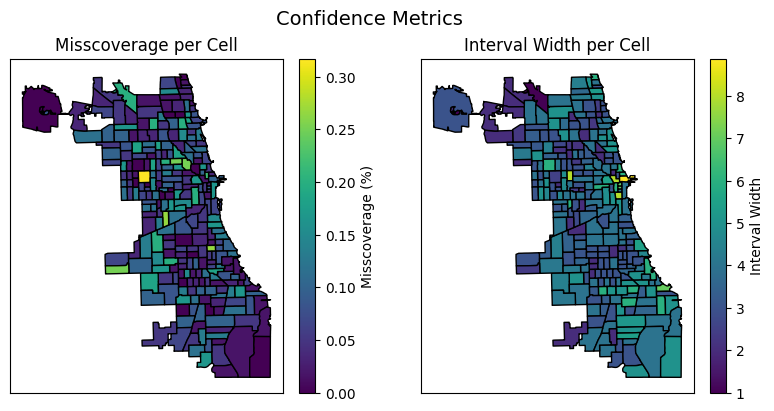

Average Misscoverage: 7.47% ± 26.29%
Average Distance Interval: 1.38 ± 1.10
Average interval width: 3.52 ± 1.45


In [41]:
grid_true, _ = predictions_to_grid(X_test, y_test, y_test, grid_size, aggregate=False)

miss_coverage=compute_misscoverage_per_cell(grid_true, y_min, y_max,X_test)
misscoverage_grid, overall_misscoverage, std_misscoverage,avg_error_outside,std_error_outside=compute_overall_misscoverage(miss_coverage)
df_misscoverage=grid_to_dataframe(misscoverage_grid, coord_to_beat_map, value_name="miss_coverage")


width_intervals=compute_interval_width_per_sample(np.repeat(y_min[None, :, :], test_days, axis=0),
                                                  np.repeat(y_max[None, :, :], test_days, axis=0),
                                                  X_test)
width_grid, overall_width, std_width=compute_overall_interval_width(width_intervals)
df_width_grid=grid_to_dataframe(width_grid, coord_to_beat_map, value_name="interval_width")


plot_prediction_maps(
    gdf_base=gdf[["BEAT_NUM", "geometry"]],
    df_list=[df_misscoverage, df_width_grid],
    columns=["miss_coverage", "interval_width"],
    titles=["Misscoverage per Cell", "Interval Width per Cell"],
    cmap="viridis",
    share_colorbar=False,
    colorbar_labels=["Misscoverage (%)", "Interval Width"],
    suptitle="Confidence Metrics",
    figsize=(8, 4)
)

print(f"Average Misscoverage: {100 * overall_misscoverage:.2f}% ± {100 * std_misscoverage:.2f}%")
print(f"Average Distance Interval: { avg_error_outside:.2f} ± {std_error_outside:.2f}")
print(f"Average interval width: {overall_width:.2f} ± {std_width:.2f}")

# 📊 Analysis of Misscoverage and Interval Width

To better understand the performance of conformal prediction intervals, we analyze the relationship between:

- **Interval Width**: an indicator of uncertainty.
- **Misscoverage**: whether the true value was not covered by the interval.
- **Distance to Interval**: how far the missed value was from the predicted interval.
- **Miss Rate**: historical coverage failure per spatial cell.

---


In [42]:
miss_coverage = miss_coverage.set_index(["timestep", "row", "col"])
width_intervals = width_intervals.set_index(["timestep", "row", "col"])

df_metrics = pd.concat([miss_coverage, width_intervals], axis=1, join="inner").reset_index()


coverage_per_cell = (
    df_metrics.groupby(["row", "col"])["not_in_interval"]
    .apply(lambda x: x.mean())
    .reset_index(name="miss_coverage")
)

# Merge con el DataFrame original
df_metrics = df_metrics.merge(coverage_per_cell, on=["row", "col"], how="left")


df_metrics = df_metrics.rename(columns={
    "not_in_interval": "Outside Interval",
    "interval_width": "Interval Width",
    "miss_coverage": "Misscoverage",
    "distance_to_interval": "Distance to Interval"
})

### 🔍 1. Hexbin Plot: Interval Width vs Distance to Interval

This plot shows the relationship between the width of the prediction interval and how far the true value was outside the interval, **only for failed predictions** (i.e., not covered).

C:\Users\capqp\AppData\Local\Temp\ipykernel_16604\3747275681.py:12: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


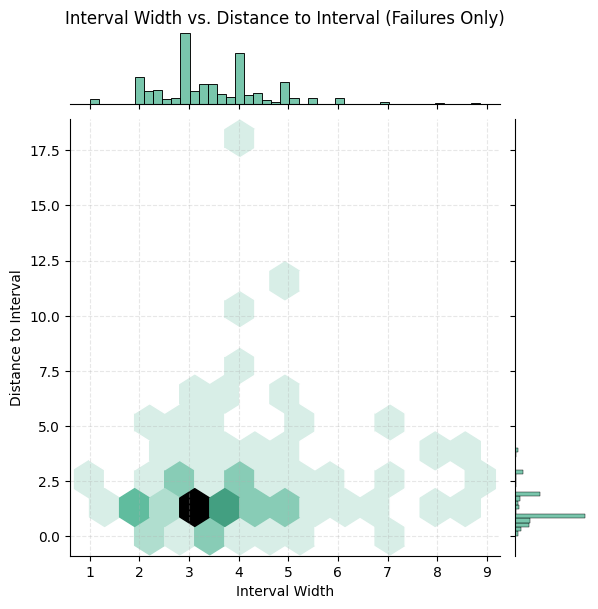

In [43]:
joint_kws = dict(gridsize=13, bins=10)
sns.jointplot(
    data=df_metrics[df_metrics["Outside Interval"]],
    x="Interval Width",
    y="Distance to Interval",
    kind="hex",
    joint_kws=joint_kws,
    color="#4CB391"
)
plt.title("Interval Width vs. Distance to Interval (Failures Only)", y=1.2)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### 🎯 2. KDE Contours: Miss Rate vs Interval Width (Colored by Coverage)
This contour plot compares the interval width and average miss rate, grouped by whether the point was covered (Yes/No) by the interval.

C:\Users\capqp\AppData\Local\Temp\ipykernel_16604\1436984842.py:22: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


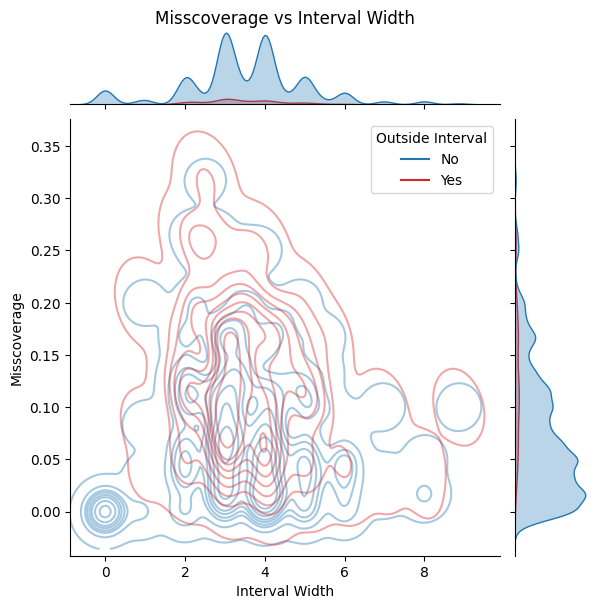

In [44]:
palette = {
    "No": "#1f77b4",  # Blue = covered
    "Yes": "#d62728"  # Red = missed
}

g = sns.jointplot(
    data=df_metrics.replace({True: "Yes", False: "No"}),
    x="Interval Width",
    y="Misscoverage",
    hue="Outside Interval",
    kind="kde",
    palette=palette,
    fill=False,
    thresh=0.005,
    levels=10,
    common_norm=False,
    marginal_kws=dict(fill=True, alpha=0.3),
    joint_kws=dict(alpha=0.4)
)

plt.title("Misscoverage vs Interval Width", y=1.2)
plt.tight_layout()
plt.show()


### 📅 3. Heatmap: Misscoverage Over Time
This heatmap summarizes the percentage of failed predictions (outside the interval) across each timestep in the test set.

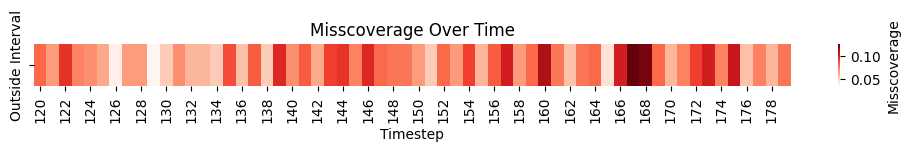

In [46]:
heatmap_data = df_metrics.groupby("timestep")["Outside Interval"].mean().to_frame()

plt.figure(figsize=(10, 1.5))
sns.heatmap(heatmap_data.T, cmap="Reds", cbar_kws={'label': 'Misscoverage'})
plt.title("Misscoverage Over Time")
plt.xlabel("Timestep")
plt.tight_layout()
plt.show()

# 🧪 Size-Stratified Coverage (SSC)

To evaluate how well the model's prediction intervals behave across different **hotspot types**, we classify each cell according to the agreement between the **predicted** and **actual** hotspots.

---

### 📐 Classification Types

Each spatiotemporal cell is labeled as:

| Label       | Description                                     |
|-------------|-------------------------------------------------|
| `Both`      | Cell is a hotspot in both prediction and truth. |
| `Pred-only` | Predicted as hotspot, but not in ground truth.  |
| `GT-only`   | Ground truth hotspot, but not predicted.        |
| `Neither`   | Not a hotspot in either.                        |

This allows for deeper stratification of coverage and interval behavior.

---

### 🧮 Step-by-step:

1. **Classify cells** using the current ground truth and prediction grids.
2. **Map timesteps** to real temporal values.
3. **Merge** with the metrics (coverage, width, etc).
4. **Aggregate** to compute average coverage (and std) per group.
5. Report the **Size-Stratified Coverage (SSC)** as a global summary.

In [48]:
# Classify each cell over time based on prediction vs. truth hotspot masks
hs_class = classify_temporal_hotspots(grid_true, grid_pred, hotspot_percentage)

# Align timestep indices
real_timesteps = sorted(df_metrics["timestep"].unique())
timestep_map = {i: real_timesteps[i] for i in range(len(real_timesteps))}
hs_class["timestep"] = hs_class["timestep"].map(timestep_map)

# Merge with confidence metrics
df_final = pd.merge(df_metrics, hs_class, on=["timestep", "row", "col"], how="inner")
df_final = df_final.rename(columns={"cell_type": "Hotspot Match Type"})

# Compute Size-Stratified Coverage (SSC)
ssc_df = df_final.groupby("Hotspot Match Type").agg({
    "Outside Interval": ["mean", "std"]
}).reset_index()

# Compute overall SSC summary
ssc_mean = ssc_df["Outside Interval"]["mean"].mean()
ssc_std = ssc_df["Outside Interval"]["std"].mean()
print(f"Size-Stratified Coverage: {ssc_mean:.2f} ± {ssc_std:.2f}")

ssc_df

Size-Stratified Coverage: 0.31 ± 0.29


Hotspot Match Type Outside Interval          
                                 mean       std
0               Both         0.295597  0.457753
1            GT-only         0.867868  0.339144
2            Neither         0.058514  0.234721
3          Pred-only         0.019090  0.136940

## 📊 Interval and Misscoverage Analysis by Hotspot Type

After classifying each cell according to its presence in predicted and actual hotspots, we analyze how the model behaves in terms of **interval width** and **misscoverage** across these categories.

---

### 🎯 Hotspot Match Types:

| Type        | Description                                                     |
|-------------|-----------------------------------------------------------------|
| `Both`      | True hotspot and predicted hotspot (ideal match)               |
| `Pred-only` | Predicted hotspot but not in ground truth                      |
| `GT-only`   | Ground truth hotspot not predicted                             |
| `Neither`   | Not a hotspot in either (background noise or inactive area)    |

---

### 🧪 Visualization Goals

1. **Boxenplot** (top):  
   Shows the **distribution of interval widths** for covered and missed predictions, across hotspot types.

2. **Stacked histogram** (bottom):  
   Shows **distance to interval** when a prediction fails, per hotspot type.

3. **Joint KDE plot** (second figure):  
   Compares the **relationship between interval width and misscoverage**, stratified by hotspot type.

---


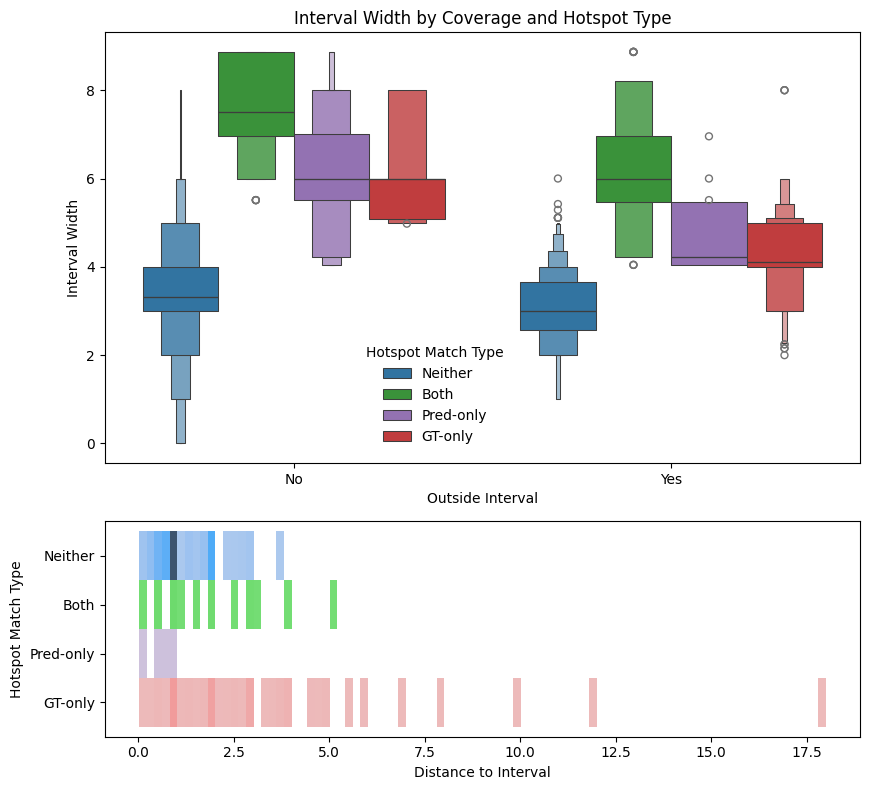

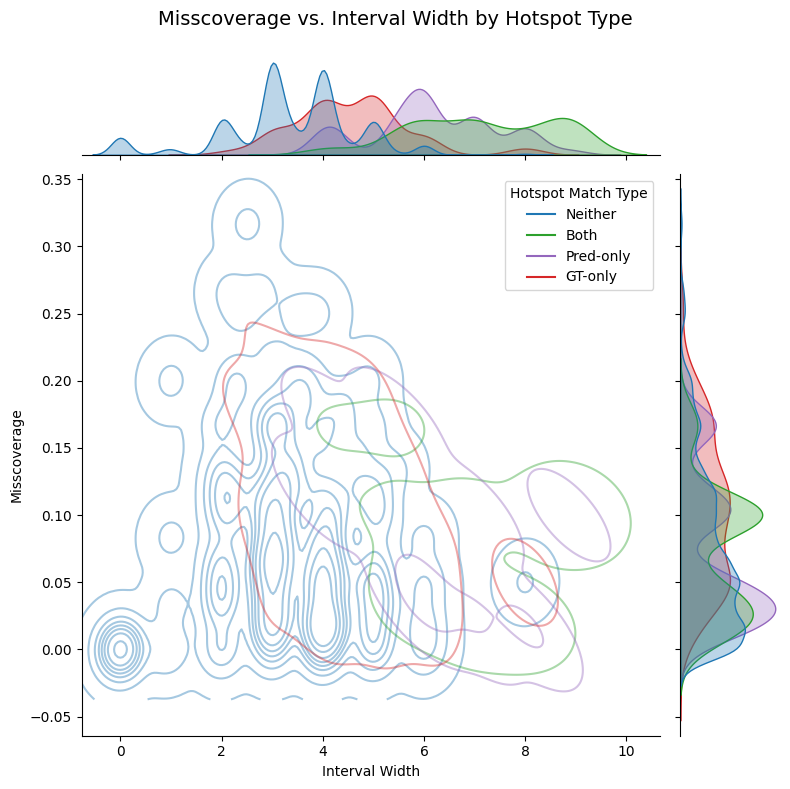

In [52]:
### 📦 Code

# Define color palette and category order
palette = {
    "Neither": "#1f77b4",
    "Both": "#2ca02c",
    "Pred-only": "#9467bd",
    "GT-only": "#d62728"
}
hue_order = ["Neither", "Both", "Pred-only", "GT-only"]

# Prepare plotting DataFrame
df_plot = df_final.copy()
df_plot["Outside Interval"] = df_plot["Outside Interval"].map({True: "Yes", False: "No"})

# Main plot: Boxenplot + stacked histogram
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=False, gridspec_kw={"height_ratios": [2, 1]})

# Boxenplot: Interval width per coverage and hotspot type
sns.boxenplot(
    data=df_plot,
    x="Outside Interval", y="Interval Width",
    hue="Hotspot Match Type",
    palette=palette,
    hue_order=hue_order,
    ax=ax1
)
ax1.set_title("Interval Width by Coverage and Hotspot Type")
ax1.legend_.remove()

# Histogram: Distance when outside interval
df_errors = df_plot[df_plot["Outside Interval"] == "Yes"].copy()
df_errors["Hotspot Match Type"] = pd.Categorical(df_errors["Hotspot Match Type"], categories=hue_order, ordered=True)

sns.histplot(
    df_errors,
    y="Hotspot Match Type",
    x="Distance to Interval",
    hue="Hotspot Match Type",
    ax=ax2,
    legend=False,
    hue_order=hue_order,
    palette=palette,
)

# Shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Hotspot Match Type", loc="center", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

# --- Joint KDE Plot: Misscoverage vs. Interval Width
g = sns.JointGrid(
    data=df_final.replace({True:"Yes",False:"No"}),
    x="Interval Width",
    y="Misscoverage",
    hue="Hotspot Match Type",
    palette=palette,
    hue_order=hue_order,
    height=8
)

g.plot_joint(sns.kdeplot, fill=False, alpha=0.4, thresh=0.005)
g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.3)

g.fig.suptitle("Misscoverage vs. Interval Width by Hotspot Type", fontsize=14)
g.set_axis_labels("Interval Width", "Misscoverage")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.92)
plt.show()

### 🔍 Confidence Metric for Hotspots

When the model predicts a cell as a hotspot, we want to estimate **how confident it is** about that prediction — even **without access to future ground truth values**. For this, we propose a practical confidence metric that relies exclusively on **the size of the predicted interval**, which captures the model's **uncertainty**.

---

#### 📐 Proposed Formula (operational spatio-temporal version):

Confidence(t, r, c) = 1 - NormalizedIntervalWidth(t, r, c)

Where:

- `NormalizedIntervalWidth(t, r, c)` is the width of the prediction interval at time `t` and cell `(r, c)`, **rescaled between 0 and 1** using the min-max range over the full dataset.

The resulting confidence score is also bounded in \([0, 1]\), where higher values indicate **greater certainty** (i.e., narrower predicted intervals).

---

#### 🧠 Interpretation:

- **High confidence (~1):** the predicted interval is narrow → the model is confident in its estimate.
- **Low confidence (~0):** the predicted interval is wide → the model is uncertain and cautious.

This metric is fully compatible with deployment scenarios where no true crime values are yet available, and supports **risk-based prioritization of hotspot areas** based on prediction reliability.


### 📊 Visualizing Hotspot Confidence Across Space and Categories
We compute and visualize the average confidence per cell over time based on interval width alone. This spatial representation supports strategic hotspot prioritization

g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)


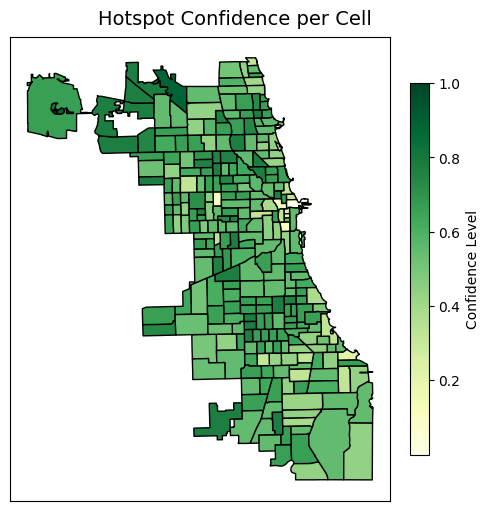

(np.float64(0.6025617681893908), np.float64(0.16362000114434505))

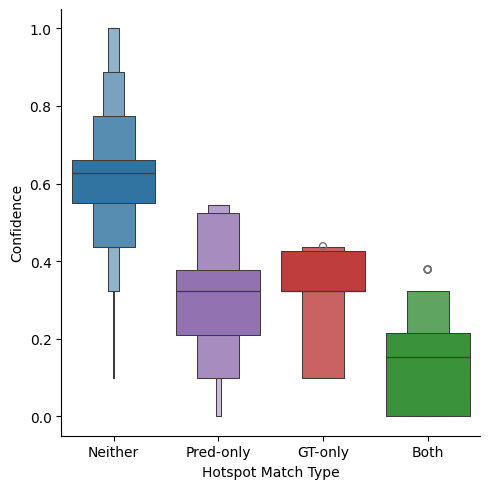

In [68]:
# Compute confidence using normalized interval width only (no need for ground truth)
df_final = compute_spatiotemporal_confidence(df_final)

# Aggregate over time to get average confidence per cell
confidence_df = df_final.groupby(["row", "col"]).agg({"Confidence": "mean"}).reset_index()

# Convert to grid for visualization
confidence_grid, _ = predictions_to_grid(confidence_df,
                                         confidence_df["Confidence"],
                                         confidence_df["Confidence"],
                                         grid_size,
                                         aggregate=False)

df_confidence = grid_to_dataframe(confidence_grid, coord_to_beat_map, value_name="confidence")

# Plot spatial confidence map
plot_prediction_maps(
    gdf[["BEAT_NUM", "geometry"]],
    [df_confidence],
    columns=["confidence"],
    titles=[""],
    cmap="YlGn",
    share_colorbar=True,
    suptitle="Hotspot Confidence per Cell",
    figsize=(5, 5),
    edgecolor="black",
    vmin=None,
    vmax=None,
    colorbar_labels=["Confidence Level"]
)

# Boxplot of confidence across hotspot types (excluding uncovered intervals)
sns.catplot(
    data=df_final[~df_final["Outside Interval"]],
    y="Confidence", x="Hotspot Match Type",
    hue="Hotspot Match Type", kind="boxen",
    palette=palette,
    hue_order=hue_order
)

# Print overall confidence statistics
df_confidence["confidence"].mean(), df_confidence["confidence"].std()

# 📌 Historical Hotspot Frequency (Train)
We compute how often each cell was classified as a hotspot during the training period. This frequency will be used to guide hotspot prioritization in conjunction with the confidence metric.

g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)


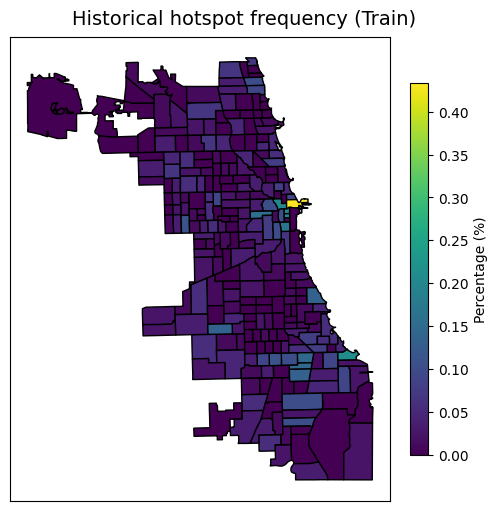

(np.float64(0.027527873894655903), np.float64(0.04536141165438931))

In [71]:
from src.utils.spatial_processing import define_hotspot_by_crimes

# Convert training set to spatiotemporal grid
train_grid, _ = predictions_to_grid(
    df_train,
    df_train["count"],
    df_train["count"],
    grid_size,
    aggregate=False
)

# Count how many times each cell was a hotspot
true_mask = []
for i in range(train_days):
    true_mask.append(define_hotspot_by_crimes(train_grid[i], hotspot_percentage))

# Average across timesteps (i.e., fraction of time each cell was selected as hotspot)
true_mask = np.mean(true_mask, axis=0)

# Convert to GeoDataFrame for plotting
df_true_mask = grid_to_dataframe(true_mask, coord_to_beat_map, value_name="percentage")

# Plot spatial distribution of historical hotspot frequency
plot_prediction_maps(
    gdf[["BEAT_NUM", "geometry"]],
    [df_true_mask],
    columns=["percentage"],
    titles=[""],
    cmap="viridis",
    share_colorbar=True,
    suptitle="Historical hotspot frequency (Train)",
    figsize=(5, 5),
    edgecolor="black",
    vmin=None,
    vmax=None,
    colorbar_labels=["Percentage (%)"]
)

# Display average historical hotspot frequency
df_true_mask["percentage"].mean(), df_true_mask["percentage"].std()


### 🔍 **Hotspot Priority Classification: Scenarios and Interpretations**

We define a **priority map** that classifies cells based on two main components:

1. **Confidence Score (0–1)**  
   Reflects how certain the model is about its predictions.  
   Lower interval width → higher confidence.  

2. **Hotspot Intensity or Frequency (0–1)**  
   This second axis depends on the **data availability** and use case:

---

#### 🧪 **Scenario 1: Historical Frequency (Post-hoc Evaluation)**

Used for analysis on **test data** or retrospective evaluations.

- **Hotspot Frequency** = proportion of times a cell was a hotspot in the ground truth.
- Helps analyze model behavior over time and validate decision criteria.

| Category        | Frequency | Confidence | Color    | Interpretation                                                                 |
|----------------|-----------|-------------|----------|---------------------------------------------------------------------------------|
| 🟥 Priority     | High      | High        | Red      | Active area with strong statistical backing → top intervention priority.       |
| 🟧 Critical     | High      | Low         | Orange   | Active area but uncertain prediction → possible false positive.                |
| 🟨 Monitoring   | Low       | Low         | Yellow   | Rarely active, uncertain → requires monitoring for emerging threats.           |
| 🟩 Low Interest | Low       | High        | Green    | Inactive and confidently predicted → deprioritize.                             |

---

#### 🚨 **Scenario 2: Normalized Prediction (Real-Time Deployment)**

Used when only the **predicted values** and **intervals** are available — as in a real-world setting.

- **Predicted Intensity** = current predicted value for a cell, normalized over the grid.
- Enables on-the-fly prioritization **without needing future observations**.

| Category        | Normalized Prediction | Confidence | Color    | Interpretation                                                                 |
|----------------|------------------------|-------------|----------|---------------------------------------------------------------------------------|
| 🟥 Priority     | High                   | High        | Red      | Area expected to have high crime, with strong model certainty.                 |
| 🟧 Critical     | High                   | Low         | Orange   | Area with high predicted crime but low model certainty — may be volatile.      |
| 🟨 Monitoring   | Low                    | Low         | Yellow   | Low predicted crime, but the model is uncertain — monitor for anomalies.       |
| 🟩 Low Interest | Low                    | High        | Green    | Calm region with confident low prediction — lowest priority.                   |

---

### 🧠 **Why Two Scenarios?**

- Use **Scenario 1** to validate your framework using ground-truth test data.
- Use **Scenario 2** to **deploy in practice**, when future outcomes are unknown.

This flexibility ensures that the framework is **both evaluable and deployable**.

## 🗺️ Visualizing Hotspot Priority Maps

Based on the previously defined confidence scores and hotspot definitions, we generate **priority maps** for three key scenarios:

### 📊 Scenarios Evaluated

1. **Historical Frequency (Train)**  
   - Computes how often each cell was a hotspot during the training phase.  
   - Represents the empirical, post-hoc view of risk.

2. **Hotspot Prediction**  
   - Binary mask based on the output of the baseline NaiveCell model.  
   - Reflects which cells were predicted as hotspots overall.

3. **Punctual Prediction**  
   - Uses the magnitude of the predicted crime values per cell (normalized).  
   - Represents real-time predictive intensity.

Each scenario is combined with the **confidence grid** to assign a priority level to each cell:

| Category        | Risk Level        | Confidence | Color    | Description                                           |
|----------------|-------------------|------------|----------|-------------------------------------------------------|
| 🟥 Priority     | High              | High       | Red      | High-risk area with strong model support             |
| 🟧 Critical     | High              | Low        | Orange   | Risky area but low model confidence → attention needed |
| 🟨 Monitoring   | Low               | Low        | Yellow   | Infrequent but uncertain predictions → keep watch    |
| 🟩 Low Interest | Low               | High       | Green    | Quiet zone with confident low predictions            |

### 📌 Visualization Notes

- Each column below represents a different priority assignment strategy.
- Colors are **manually assigned** based on the classification output.
- The same **spatial geometry (police beats)** is used across maps for consistency.



g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)
g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["beat"] = df[["row", "col"]].apply(lambda x: beat_to_coord_map.get((x[0], x[1]), None), axis=1)
g:\Shared drives\Doctorado\Repositorios\uncertainty-informed-decision-making\src\utils\spatial_processing.

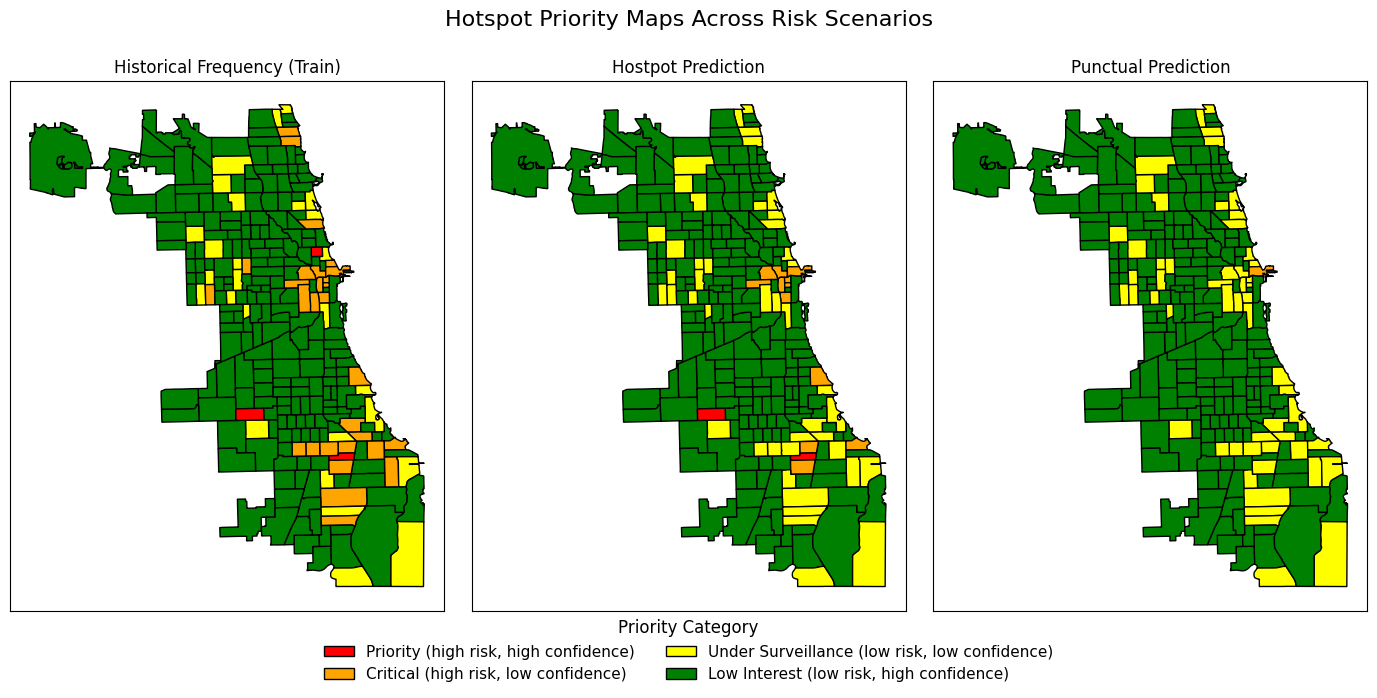

In [75]:
hotspots_dir="../../results/hotspots/real_data/Chicago/"
hotspot_naive = joblib.load(os.path.join(hotspots_dir,"naive_hotspot_prediction.pkl"))

Priority={
    "Historical Frequency (Train)":{"base":true_mask,"base_type":"frequency","freq_thresh":0.07},
    "Hostpot Prediction": {"base":hotspot_naive,"base_type":"binary","freq_thresh":None},
    "Punctual Prediction": {"base":grid_pred,"base_type":"continuous","freq_thresh":0.80},
}

for i in Priority:
    category_grid, legend=hotspot_priority(
                                            confidence_grid,
                                            Priority[i]["base"],
                                            base_type=Priority[i]["base_type"],
                                            freq_thresh=Priority[i]["freq_thresh"],
                                            conf_thresh=0.5#confidence_grid.mean()
                                        )
    Priority[i]["P"]=category_grid

########## Save
for name, values in Priority.items():
    grid = values["P"]  
    file_name = name.lower().replace(" ", "_") + "_priority_naive.npy"
    np.save(os.path.join(hotspots_dir, file_name), grid)


from matplotlib.patches import Patch

# Diccionario de categorías a colores
category_colors = {
    "Priority (high risk, high confidence)": "red",
    "Critical (high risk, low confidence)": "orange",
    "Under Surveillance (low risk, low confidence)": "yellow",
    "Low Interest (low risk, high confidence)": "green"
}

# Lista de categorías en orden deseado (leyenda)
priority_labels = list(category_colors.keys())

# Figuras en columnas
fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharex=True, sharey=True)

for ax, (title, priority_data) in zip(axes, Priority.items()):
    df_priority = grid_to_dataframe(priority_data["P"], coord_to_beat_map, value_name="priority")
    df_priority["priority"] = df_priority["priority"].replace(legend)
    gdf_plot = gdf[["BEAT_NUM", "geometry"]].merge(
        df_priority, how="left", left_on="BEAT_NUM", right_on="beat"
    )

    gdf_plot = gdf_plot[gdf_plot["priority"].notna()].copy()
    gdf_plot["color"] = gdf_plot["priority"].map(category_colors)

    gdf_plot.plot(
        color=gdf_plot["color"],
        ax=ax,
        edgecolor="black"
    )
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

# Crear elementos de leyenda
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in category_colors.items()
]

# Leyenda inferior
fig.legend(
    handles=legend_elements,
    title="Priority Category",
    loc="lower center",
    frameon=False,
    ncol=2,
    fontsize=11,
    title_fontsize=12,
    bbox_to_anchor=(0.5, 0)
)

# Título general
fig.suptitle("Hotspot Priority Maps Across Risk Scenarios", fontsize=16)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
plt.show()


# ✅ Hotspot Priority Sensitivity Grid Generation
We explore how the priority classification and resulting hotspot masks change under varying thresholds of:

📈 Risk proxy (either historical frequency, binary hotspot prediction, or continuous predicted intensity)

📉 Prediction confidence

We build a comprehensive set of spatio-temporal hotspot masks for each configuration, to be evaluated later in a separate notebook.

In [76]:
import pickle


# Thresholds for exploration
freq_thresholds_hist = np.linspace(true_mask.min(), true_mask.max(), 10)
freq_thresholds_pred = np.linspace(grid_pred.min() / grid_pred.max(), 1.0, 10)
confidence_thresholds = np.linspace(0.10, 0.95, 10)

# Dictionary to store masks
hotspot_masks_results = {
    "Historical Frequency (Train)": {},
    "Hostpot Prediction": {},
    "Punctual Prediction": {}
}

# Generate all combinations of hotspot priority masks
for scenario, params in Priority.items():

    if scenario == "Hostpot Prediction":
        for freq_thresh in freq_thresholds_pred:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

    elif scenario == "Historical Frequency (Train)":
        for freq_thresh in freq_thresholds_hist:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

    elif scenario == "Punctual Prediction":
        for freq_thresh in freq_thresholds_pred:
            for conf_thresh in confidence_thresholds:
                category_grid, _ = hotspot_priority(
                    confidence_grid,
                    params["base"],
                    base_type=params["base_type"],
                    freq_thresh=freq_thresh,
                    conf_thresh=conf_thresh
                )
                key = f"freq_{freq_thresh:.2f}_conf_{conf_thresh:.2f}"
                hotspot_masks_results[scenario][key] = category_grid

# Save masks dictionary for later evaluation
file_name = "naive_hotspot_masks_sensitivity.pkl"
with open(os.path.join(hotspots_dir, file_name), "wb") as f:
    pickle.dump(hotspot_masks_results, f)
